In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

These two major transfer learning scenarios look as follows:

Finetuning the ConvNet: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

### Download the Dataset

In [4]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -O hymenoptera_data.zip


--2024-10-19 10:17:54--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.166.68, 13.35.166.127, 13.35.166.78, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.166.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: 'hymenoptera_data.zip'

hymenoptera_data.zi 100%[===================>]  45.10M  14.6MB/s    in 3.1s    

2024-10-19 10:17:58 (14.6 MB/s) - 'hymenoptera_data.zip' saved [47286322/47286322]



### Extract the ZIP File

In [5]:
import zipfile

# Extract the downloaded zip file
with zipfile.ZipFile('hymenoptera_data.zip', 'r') as zip_ref:
    zip_ref.extractall('hymenoptera_data')


### Verify the extracted Data

In [6]:
import os

# List the extracted directories
extracted_dir = 'hymenoptera_data'
for root, dirs, files in os.walk(extracted_dir):
    print(root, dirs, files)


hymenoptera_data ['hymenoptera_data'] []
hymenoptera_data/hymenoptera_data ['train', 'val'] []
hymenoptera_data/hymenoptera_data/train ['ants', 'bees'] []
hymenoptera_data/hymenoptera_data/train/ants [] ['506249802_207cd979b4.jpg', '24335309_c5ea483bb8.jpg', 'Ant_1.jpg', 'kurokusa.jpg', '275429470_b2d7d9290b.jpg', '543417860_b14237f569.jpg', '533848102_70a85ad6dd.jpg', '28847243_e79fe052cd.jpg', '67270775_e9fdf77e9d.jpg', '892108839_f1aad4ca46.jpg', '20935278_9190345f6b.jpg', '560966032_988f4d7bc4.jpg', '339670531_94b75ae47a.jpg', 'MehdiabadiAnt2_600.jpg', 'army-ants-red-picture.jpg', '1368913450_e146e2fb6d.jpg', '998118368_6ac1d91f81.jpg', '957233405_25c1d1187b.jpg', '541630764_dbd285d63c.jpg', '466430434_4000737de9.jpg', '175998972.jpg', '707895295_009cf23188.jpg', '36439863_0bec9f554f.jpg', '1693954099_46d4c20605.jpg', '2288450226_a6e96e8fdf.jpg', '196757565_326437f5fe.jpg', '1262877379_64fcada201.jpg', '506249836_717b73f540.jpg', '334167043_cbd1adaeb9.jpg', '1099452230_d1949d3250.j

In [9]:
%%writefile utils.py

!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -O hymenoptera_data.zip

import zipfile

# Extract the downloaded zip file
with zipfile.ZipFile('hymenoptera_data.zip', 'r') as zip_ref:
    zip_ref.extractall('hymenoptera_data')

import os

# List the extracted directories
extracted_dir = 'hymenoptera_data'
for root, dirs, files in os.walk(extracted_dir):
    print(root, dirs, files)


Writing utils.py


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/working/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

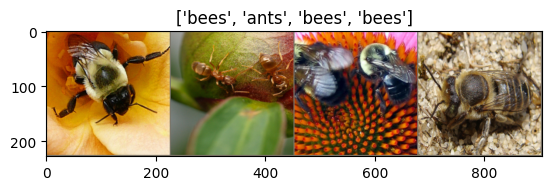

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate

Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

### Visualizing the model predictions

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Finetuning the ConvNet

In [13]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5453 Acc: 0.7377
val Loss: 0.2421 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4447 Acc: 0.8074
val Loss: 0.1906 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5278 Acc: 0.7869
val Loss: 0.4311 Acc: 0.8170

Epoch 3/24
----------
train Loss: 0.5086 Acc: 0.8033
val Loss: 0.2838 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.5741 Acc: 0.7705
val Loss: 0.5582 Acc: 0.7712

Epoch 5/24
----------
train Loss: 0.4363 Acc: 0.8484
val Loss: 0.4138 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.5730 Acc: 0.8033
val Loss: 0.2995 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.5868 Acc: 0.8197
val Loss: 0.2654 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3207 Acc: 0.8484
val Loss: 0.2525 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2204 Acc: 0.9139
val Loss: 0.2663 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2867 Acc: 0.8852
val Loss: 0.2429 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2567 Acc: 0.8607
val Loss: 0.2247 Acc: 0.9216

Ep

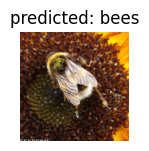

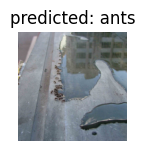

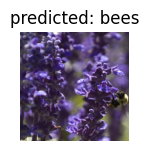

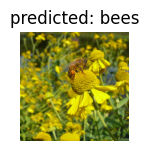

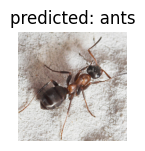

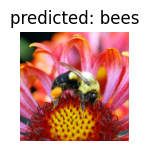

In [15]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor

In [16]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### Train and evaluate

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5338 Acc: 0.7049
val Loss: 0.2064 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5066 Acc: 0.7418
val Loss: 0.2354 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.5970 Acc: 0.7459
val Loss: 0.3804 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.4564 Acc: 0.7951
val Loss: 0.1865 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4723 Acc: 0.8033
val Loss: 0.2153 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.5844 Acc: 0.7623
val Loss: 0.2973 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.4136 Acc: 0.8033
val Loss: 0.2712 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3958 Acc: 0.8033
val Loss: 0.2035 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3167 Acc: 0.8730
val Loss: 0.2014 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4251 Acc: 0.8197
val Loss: 0.2088 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3193 Acc: 0.8525
val Loss: 0.2671 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3396 Acc: 0.8607
val Loss: 0.2033 Acc: 0.9281

Ep

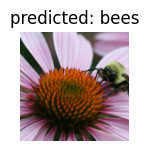

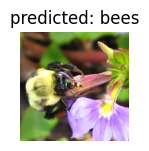

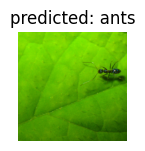

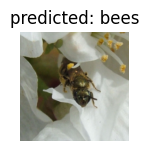

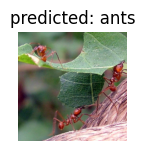

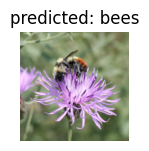

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

#### Inference on custom images

In [19]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

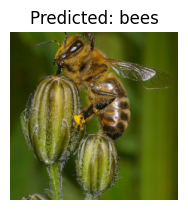

In [21]:
visualize_model_predictions(
    model_conv,
    img_path='/kaggle/working/hymenoptera_data/hymenoptera_data/val/bees/2086294791_6f3789d8a6.jpg'
)

plt.ioff()
plt.show()